# Example 4: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

create the two moon dataset

cuda


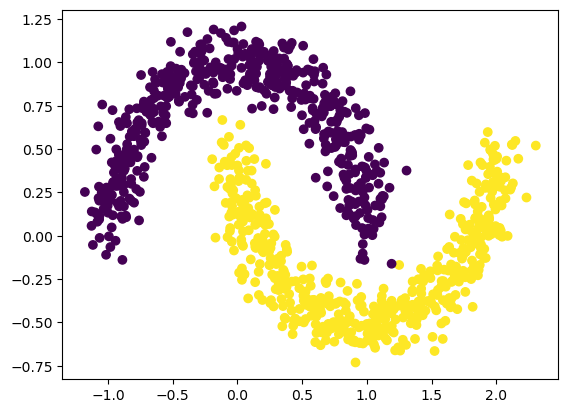

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

Train KAN

In [2]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 1.56e-01 | reg: 3.94e+00 | : 100%|█| 20/20 [00:01<00:00, 15.55it

saving model version 0.1


(1.0, 0.9980000257492065)

Automatic symbolic regression

In [3]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9654733538627625, c=2
fixing (0,1,0) with x, r2=0.975755512714386, c=1
saving model version 0.2


-0.853*x_2 - 0.3885*sin(3.1242*x_1 - 1.5464) + 0.7063

How accurate is this formula?

In [4]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9980, device='cuda:0')
test acc of the formula: tensor(0.9970, device='cuda:0')


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

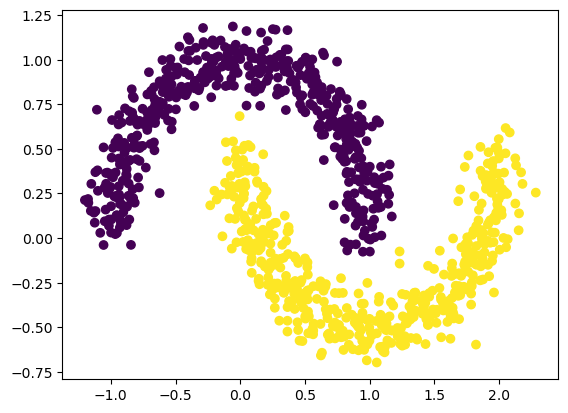

In [5]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

### Train KAN

In [7]:
model = KAN(width=[2,2], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 2.37e-01 | reg: 4.10e+02 | : 100%|█| 20/20 [00:01<00:00, 18.81it

saving model version 0.1


Automatic symbolic regression

In [8]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.48220324516296387, c=1
fixing (0,0,1) with x, r2=0.3202315866947174, c=1
fixing (0,1,0) with x, r2=0.9358773231506348, c=1
fixing (0,1,1) with x, r2=0.9290410876274109, c=1
saving model version 0.2


In [9]:
formula1, formula2 = model.symbolic_formula()[0]
ex_round(formula1, 4)

-15.0316*x_1 + 177.9349*x_2 - 63.0716

In [10]:
ex_round(formula2, 4)

60.4718*x_1 - 156.0295*x_2 + 16.9

How accurate is this formula?

In [11]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.8870, device='cuda:0')
test acc of the formula: tensor(0.8810, device='cuda:0')
